# Plot overlap matrix of SYJ_gayageum

## Find distance matrix

In [1]:
########################################## FIND DIST_MAT ##########################################
        
import networkx as nx
from sympy import zeros
import numpy as np

songname = 'syj_gayageum'


output_nodelist = songname + '_nodelist.txt'
output_distmat = songname + '_distmat.txt'



allnode = songname + '_allnode.txt'

L = np.loadtxt(allnode)

G = nx.Graph()
G.add_nodes_from(L)

for i in range(len(L)-1):
#     if int(L[i])!= 0 and int(L[i+1])!=0:
    if L[i] != L[i+1]:
        e0 = L[i]
        e1 = L[i+1]
        if G.has_edge(e0,e1): 
            G[e0][e1]['weight'] += 1
        else:
            G.add_edge(e0,e1,weight=1)
        
# find nodelist and save to a file
nodelist = list(G.nodes)
with open(output_nodelist,'w') as f:
    for node in nodelist:
        f.write('%s\n' % node)   
        

# find distance matrix
distmat = zeros(len(G.nodes))
for i in range(len(G.nodes)):
    for j in range(i,len(G.nodes)):
        if j == i:
            distmat[i,j] = 0
        else:
            path = nx.shortest_path(G,nodelist[i],nodelist[j]) # shortest_path
            for k in range(len(path)-1):
                distmat[i,j] += 1/G[path[k]][path[k+1]]['weight']
        distmat[j,i] = distmat[i,j]

# write distance matrix to a file
mat = np.matrix(distmat)
with open(output_distmat,'w') as f:
    for line in mat:
        np.savetxt(f,line,fmt='%.15f')

## (Run Matlab code after this step to find annotated intervals.)

## extract cycle info

In [2]:
def d1_info(filename): # filename = input_matlabinfo
    import json  
    f = open(filename,'r'); l = len(f.readlines())
    f = open(filename,'r')
    
    s = []
    for i in range(l):
        s.append(f.readline())
        
    # dim1 info
    d1s = []    
    for i in range(l):
        if s[i] == 'Dimension: 1\n':
            start_inx = i+1
    for j in range(start_inx,l):        
        if s[j] == 'Dimension: 2\n' or s[j] == '\n':
            end_inx = j
            break
    for k in range(start_inx,end_inx):        
            d1s.append(s[k])
            
    # get cycle info      
    c_info = []        
    for i in range(len(d1s)):
        ci_int,ci = d1s[i].split(': ')  
        ci = ci.split('\n')[0]
        ci_edge = ci.split(' + ')
        for j in range(len(ci_edge)):
            if ci_edge[j][0] == '-':
                ci_edge[j] = json.loads(ci_edge[j][1:])
                ci_edge[j] = ci_edge[j][::-1]
            else:
                ci_edge[j] = json.loads(ci_edge[j])
        ci_node = []
        for k in range(len(ci_edge)):
            for node in ci_edge[k]:
                if not(node in ci_node):
                    ci_node.append(node)
        ci_node.sort()
        c_info.append([ci_node,ci_int,ci_edge])
    c = []
    e = []
    for i in range(len(c_info)):
        c.append(c_info[i][0])
        e.append(c_info[i][2])    
    return d1s,c,e    
############################################################################### 

input_matlabinfo = songname + '_intervals.txt'
output = songname + '_cycleinfo_matlabinx.txt'



_,c,_ = d1_info(input_matlabinfo)
# write cycle info to a file
with open(output,'w') as f:
    for item in c:
        f.write('%s\n' %item)



In [3]:
c

[[2, 4, 5, 6],
 [31, 32, 33, 34],
 [2, 3, 14, 15],
 [0, 20, 21, 32, 42],
 [2, 3, 10, 11, 12],
 [31, 34, 36, 39],
 [0, 2, 3, 19, 20, 26, 27, 28, 29, 30],
 [31, 36, 37, 38],
 [0, 2, 3, 19, 31, 32, 33, 43, 44],
 [0, 16, 25, 26],
 [31, 36, 37, 40, 41]]

## convert music ordered (matlab) index to pitch ordered index

In [4]:
# convert node index from MUSIC ORDERED (matlab result) -> PITCH ORDERED (paper)
import numpy as np
import json

nl = np.loadtxt(songname+'_nodelist.txt',delimiter=',')
in_matlabinx = open(songname+'_cycleinfo_matlabinx.txt')
out_paperinx = songname+'_cycleinfo_pitchinx.txt'


def convert(nl,in_matlabinx,out_paperinx):
    f = in_matlabinx
    nls = sorted(nl)
    paperinx = []
    Lines = f.readlines()
    for line in Lines:
        ci = json.loads(line)
        ci_paperinx = []
        for i in ci:
            n = nl[i]
            for j,node in enumerate(nls):
                if node == n:
                    ci_paperinx.append(j)
        paperinx.append(ci_paperinx)
        with open(out_paperinx,'w') as outf:
            for ci_p in paperinx:
                outf.write('%s\n' % ci_p)
convert(nl,in_matlabinx,out_paperinx)




                

## Plot overlap matrix

In [5]:
####### Cycle node numbers ##################
import json
f = open(songname+'_cycleinfo_pitchinx.txt')
c = []
Lines = f.readlines()
for line in Lines:
    ci = json.loads(line)
    c.append(ci)

import numpy as np
L = list(np.loadtxt(songname+'_allnode.txt',delimiter=','))    
nodelist = list(np.loadtxt(songname+'_nodelist.txt',delimiter=','))
nodelist = sorted(nodelist)    

def nodeoverlap(c, L, nodelist):
    matrix = []; 
    for ci in c: # [0 6 19 20]
        row = []
        for node in L:
            inx = nodelist.index(node)
            if inx in ci:
#                 row.append(inx+1)
#                row.append(ci.index(inx)+1)
                row.append(1)
            else:
                row.append(0)
        matrix.append(row)
    for q in [3]:#range(1,8):#[3,4,5]:
        mat = [];
        for j,row in enumerate(matrix):
            new = []; leng = 0
            # construct new row
            for i,node in enumerate(row):
                if node == 0:
                    if leng == 0:
                        new.append(0)
                    else:
                        if leng > q:
                            new += row[i-leng:i]+[0]
                        else:
                            new += [0]*leng+[0]
                        leng = 0
                else:
                    leng += 1
            if leng != 0:
                if leng > q:
                    new += row[len(row)-leng:]
                else:
                    new += [0]*leng
            mat.append(new)
    
    return mat

mat1 = nodeoverlap(c, L, nodelist)  




In [6]:
import matplotlib.pyplot as plt

import seaborn as sns

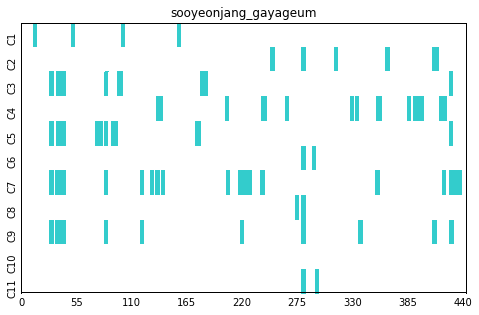

In [7]:
# plot overlap matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

from matplotlib.colors import ListedColormap


ax=sns.heatmap(mat1, cmap=ListedColormap(['white', (0.2,0.8,0.8)]),yticklabels = ['C'+str(i+1) for i in range(len(mat1))],cbar=False)



ax.axhline(y = 0, color='k',linewidth = 1)
ax.axhline(y = len(mat1)-0.1, color = 'k',
            linewidth = 1)
  
ax.axvline(x = 0, color = 'k',
            linewidth = 1)
  
ax.axvline(x = len(mat1[0])-0.6, 
            color = 'k', linewidth = 1)


n = 5  
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]




plt.setp(ax.get_xticklabels(), rotation=360)
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.title(songname)
# plt.savefig(songname,bbox_inches='tight')
# plt.show()
# plt.title('SJC_daegeum_gukakjeonjip')
# plt.savefig('/Users/mailan/Dropbox/21_12_17_workshop/SJC_daegeum_gukakjeonjip',bbox_inches='tight')
plt.show()

In [8]:
########### DENSENESS ####################
count = 0
for row in mat1:
    for i,node in enumerate(row):
        if node != 0:
            count += 1 
density = count/(len(mat1[0])*len(c))
print('The denseness of {} = '.format(songname), density)

########### OVERLAP ####################
s = np.zeros(len(mat1[0]))    
for i in range(len(mat1)):
    s += np.array(mat1[i])
count_overlap = 0
count_singlecycle = 0
count_nocycle = 0
for i in range(len(s)):
    if s[i] >= 2:
        count_overlap += 1
    elif s[i] == 1:
        count_singlecycle += 1
    elif s[i] == 0:
        count_nocycle += 1
print('The overlap percentage = ',count_overlap/(len(s)-count_nocycle)*100,'%' )    
# print('more than one cycle played = ', count_overlap)
# print('single cycle played =  ',count_singlecycle)
# print('no cycle played = ',count_nocycle)
# if count_overlap > 0:
#    print('max number of cycle overlapping = ',max(s))



The denseness of sooyeonjang_gayageum =  0.06843718079673136
The overlap percentage =  33.65853658536586 %


In [9]:
# new def of Overlaping percentage (">= 2 cycle"/ music length)
print('NEW DEF: The overlap percentage = ',count_overlap/len(s)/len(c)*100,'%' )    

NEW DEF: The overlap percentage =  1.4096016343207356 %
